In [1]:
#1.Remove nans and others + 
#2.Split trian,valid, test + 
#3.downsample Train + 
#4.Feature selection +
#5.Lightgbm +
#6.Hyp. Tunnig 
#7.Feature engineering
#8.Ensembling multiple models

In [2]:
#Importing libraries
import vaex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os
from vaex.ml import LabelEncoder
from tqdm import tqdm
from sklearn.feature_selection import  f_classif
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn')

INFO:MainThread:numexpr.utils:NumExpr defaulting to 2 threads.


In [3]:
%%time
#Open data
data = vaex.open('CRA_Train_all.parquet')

Wall time: 3.48 s


In [4]:
data.shape

(6332517, 419)

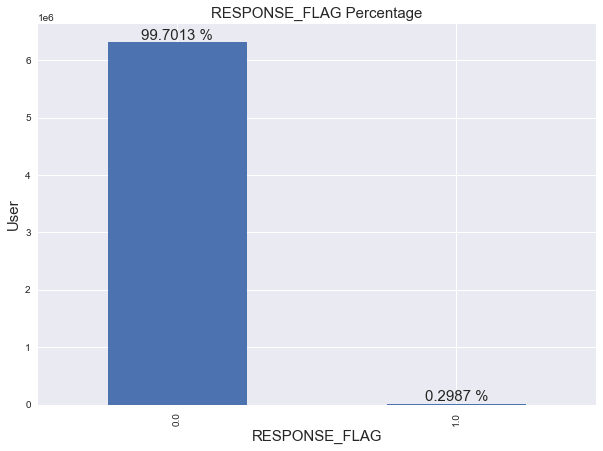

In [5]:
#Show class imbalance
plt.figure(figsize = (10,7))
data['RESPONSE_FLAG'].value_counts().plot(kind = 'bar')
percent_1 = round(data['RESPONSE_FLAG'].value_counts()[1] / data.shape[0] * 100,5)
percent_0 = round(data['RESPONSE_FLAG'].value_counts()[0] / data.shape[0]* 100,5)
plt.text(0,data['RESPONSE_FLAG'].value_counts()[0]+40000,str(percent_0)+' %',fontsize = 15,horizontalalignment='center')
plt.text(1,data['RESPONSE_FLAG'].value_counts()[1]+40000,str(percent_1)+' %',fontsize = 15,horizontalalignment='center')
plt.xlabel('RESPONSE_FLAG',fontsize = 15)
plt.ylabel('User',fontsize = 15)
plt.title('RESPONSE_FLAG Percentage',fontsize = 15)
plt.show()

In [6]:
#Collect columns with more then 50% Nan values and nan values, with 1 unique values
if not os.path.exists('features_to_drop.json'):
    features_to_drop = {'to_drop':[],'with_nans':[]}
    
    for col in tqdm(list(data.columns)):
        num_null = pd.Series(data[col].values).isna().sum()
        num_uniq = pd.Series(data[col].values).nunique()
        if num_null >= data.shape[0] / 2 or num_uniq == 1:
            features_to_drop['to_drop'].append(col)
        elif num_null != 0:
            features_to_drop['with_nans'].append(f'{col} with {num_null} Nan values')
           
    with open('features_to_drop.json', 'w') as fd:
        json.dump(features_to_drop, fd)
        
    with open('features_to_drop.json', 'r') as fd:
        features_to_drop = json.load(fd)
        
    features_to_drop['to_drop'] = set(features_to_drop['to_drop'])
    features_to_drop['with_nans'] = set(features_to_drop['with_nans'])
else:
    with open('features_to_drop.json', 'r') as fd:
        features_to_drop = json.load(fd)
    features_to_drop['to_drop'] = set(features_to_drop['to_drop'])
    features_to_drop['with_nans'] = set(features_to_drop['with_nans'])

In [7]:
#Features that have less then 50% nan values
features_to_drop['with_nans']

{'DEM02 with 7850 Nan values', 'ENCRYPTED_PIN with 988196 Nan values'}

In [8]:
#Also drop ENCRYPTED_PIN
features_to_drop['to_drop'].add('ENCRYPTED_PIN')

In [9]:
#Drop unnecessary
data = data.drop(columns = list(features_to_drop['to_drop']))

In [10]:
#Divide categorical and numeric features, find categorical features with high cardinality  
strings = []
floats = []
for col in data.column_names:
    if data[col].dtype == "string":
        strings.append(col)
        print(col,data[col].nunique(), 'Unique values')
    else:
        floats.append(col)

STATE_CD 32 Unique values
SEGMENT_CODE 8 Unique values
DEM03 4 Unique values
DEM06 3 Unique values
DEM07 5 Unique values
DEM08 14 Unique values
DEM09 5 Unique values
SMARTV40_AAU19 19 Unique values
SMARTV40_AAU20 13 Unique values
SMARTV40_AAU22 12 Unique values
SMARTV40_ALE21 12 Unique values
AXM5031T 6 Unique values
AXM5033T 6 Unique values
BRC5031T 7 Unique values
BRC5033T 7 Unique values
KEYID 4079386 Unique values
RESPONSE_FLAG_ORIGINAL 5 Unique values


In [11]:
# #Drop categorical features with high cardinality 
data = data.drop(['KEYID','RESPONSE_FLAG_ORIGINAL'])
strings.remove('KEYID')
strings.remove('RESPONSE_FLAG_ORIGINAL')
data.shape

(6332517, 373)

In [12]:
%%time
#Encode cat. features to numeric
label_encoder = vaex.ml.LabelEncoder(features=strings)
data_str = label_encoder.fit_transform(data[strings])
data = data.drop(strings)


Wall time: 19.5 s


In [13]:
#Vaex adds features not chainging them, so we have to choose that changed features
needed_col = [i for i in data_str.column_names if 'label_encoded' in i]
needed_col

['label_encoded_STATE_CD',
 'label_encoded_SEGMENT_CODE',
 'label_encoded_DEM03',
 'label_encoded_DEM06',
 'label_encoded_DEM07',
 'label_encoded_DEM08',
 'label_encoded_DEM09',
 'label_encoded_SMARTV40_AAU19',
 'label_encoded_SMARTV40_AAU20',
 'label_encoded_SMARTV40_AAU22',
 'label_encoded_SMARTV40_ALE21',
 'label_encoded_AXM5031T',
 'label_encoded_AXM5033T',
 'label_encoded_BRC5031T',
 'label_encoded_BRC5033T']

In [14]:
#Add Encoded features to main data
for col in needed_col:
    data[col] = data_str[col].values

In [15]:
#Fill remaining nan values
mode = pd.Series(data.DEM02.values).mode()[0]
data['new_DEM02'] = np.array(pd.Series(data.DEM02.values).fillna(mode))

data = data.drop('DEM02')

In [16]:
#Divide into train and test parts
data_train, data_test = data.ml.train_test_split(test_size=0.2, verbose=False,)
data_val,  data_test = data_test.ml.train_test_split(test_size=0.5, verbose=False)

In [17]:
data_train.groupby(by = ['EXP_ID','RESPONSE_FLAG'],agg={'EXP_ID1': vaex.agg.count('EXP_ID')})

#,EXP_ID,RESPONSE_FLAG,EXP_ID1
0,62,0.0,881348
1,62,1.0,2081
2,66,0.0,262797
3,66,1.0,948
4,56,0.0,620671
...,...,...,...
13,72,1.0,2138
14,68,0.0,469092
15,68,1.0,1419
16,88,0.0,328460


In [18]:
#Undersample data
downsampled = vaex.from_pandas(pd.DataFrame(columns = data_train.column_names))

for exp in data_train['EXP_ID'].unique():
    
    data_0 = data_train[(data_train.EXP_ID == exp) & (data_train.RESPONSE_FLAG == 0)]
    data_1 = data_train[(data_train.EXP_ID == exp) & (data_train.RESPONSE_FLAG == 1)]
    
    data_0 = data_0.sample(n = data_1.shape[0]+300, random_state=42)
    downsampled = vaex.concat([downsampled,data_0,data_1])
    print(f'Exp_ID {exp} done!')

Exp_ID 62 done!
Exp_ID 66 done!
Exp_ID 56 done!
Exp_ID 60 done!
Exp_ID 72 done!
Exp_ID 84 done!
Exp_ID 76 done!
Exp_ID 68 done!
Exp_ID 88 done!


In [19]:
downsampled.shape

(32650, 373)

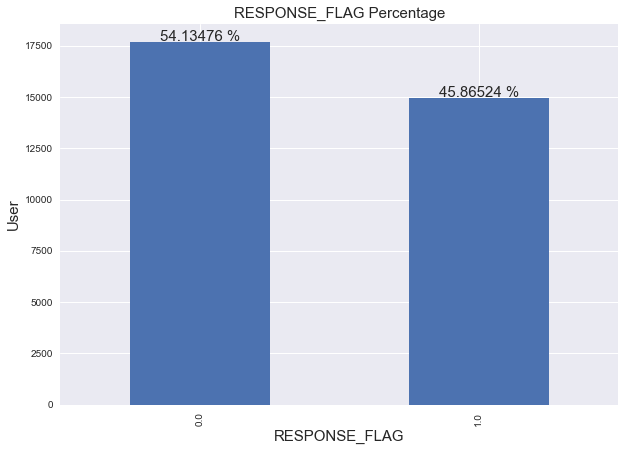

In [20]:
plt.figure(figsize = (10,7))
downsampled['RESPONSE_FLAG'].value_counts().plot(kind = 'bar')
percent_1 = round(downsampled['RESPONSE_FLAG'].value_counts()[1] / downsampled.shape[0] * 100,5)
percent_0 = round(downsampled['RESPONSE_FLAG'].value_counts()[0] / downsampled.shape[0]* 100,5)
plt.text(0,downsampled['RESPONSE_FLAG'].value_counts()[0]+40,str(percent_0)+' %',fontsize = 15,horizontalalignment='center')
plt.text(1,downsampled['RESPONSE_FLAG'].value_counts()[1]+40,str(percent_1)+' %',fontsize = 15,horizontalalignment='center')
plt.xlabel('RESPONSE_FLAG',fontsize = 15)
plt.ylabel('User',fontsize = 15)
plt.title('RESPONSE_FLAG Percentage',fontsize = 15)
plt.show()

In [21]:
if not os.path.exists('anova_dict.json'):
    anova_dict = {}
    for col in tqdm(downsampled.column_names):
        if col != 'RESPONSE_FLAG':
            score = f_classif(np.array(downsampled[col].values).reshape(-1,1), target)[0][0]
            if score > 0:
                anova_dict[col] = score
    anova_dict = dict(sorted(anova_dict.items(),key = lambda  x: x[1],reverse=True))
                      
    with open('anova_dict.json', 'w') as cd:
        json.dump(anova_dict, cd)

    with open('anova_dict.json', 'r') as cd:
        anova_dict = json.load(cd)
        
else:
    with open('anova_dict.json', 'r') as cd:
        anova_dict = json.load(cd)
    anova_dict = {key:value for key,value in zip(list(anova_dict.keys()), list(anova_dict.values())) if value >= 0}
    anova_dict = dict(sorted(anova_dict.items(),key = lambda  x: x[1],reverse=True))

In [22]:
anova_dict

{'SMARTV40_ARV39': 1539.520032161681,
 'SMARTV40_AAL27': 1297.2537006032467,
 'SMARTV40_AAL19': 1198.0318781794117,
 'SMARTV40_AAL18': 1093.7269108598475,
 'SMARTV40_ARV15': 897.2137225425269,
 'SMARTV40_AMG11': 854.9243318604048,
 'AXM5131T': 822.0851590833314,
 'SMARTV40_ARV31': 817.1180920019366,
 'SMARTV40_AMG47': 815.6118526034992,
 'SMARTV40_AMG44': 807.8927409310526,
 'SMARTV40_AMG10': 794.2448924258221,
 'AXM5130T': 789.2771747570747,
 'SMARTV40_AMG09': 788.4288276023415,
 'SMARTV40_ARV16': 765.1964857409273,
 'SMARTV40_AMG46': 762.1568091744567,
 'SMARTV40_ARV33': 762.0674201661875,
 'SMARTV40_ABK22': 753.1077765906833,
 'SMARTV40_AMG08': 738.9522136846966,
 'AXM4970T': 711.9969777476527,
 'SMARTV40_AMG45': 702.3647927484557,
 'SMARTV40_ARV20': 691.2728055338886,
 'SMARTV40_ARV40': 682.3798009396701,
 'SMARTV40_ARV19': 660.384535032246,
 'SMARTV40_ABK20': 629.7798797783615,
 'SMARTV40_ARV14': 619.827371914757,
 'SMARTV40_ABK19': 611.7730450026875,
 'SMARTV40_ABK31': 609.370765

In [39]:
%%time
if not os.path.exists('dataframe.csv'):
    dataframe =  downsampled.to_pandas_df(list(anova_dict.keys())[:100])
    dataframe['target'] = np.array(downsampled.RESPONSE_FLAG.values)
    dataframe.to_csv('dataframe.csv',index=False)
else:
    dataframe = pd.read_csv('dataframe.csv')
    

Wall time: 638 ms


In [42]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier
rfe_selector = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=30, step=5, verbose=5)
rfe_selector.fit(dataframe[dataframe.columns.difference(['target'])], dataframe['target'])
rfe_support = rfe_selector.get_support()
rfe_feature = dataframe[dataframe.columns.difference(['target'])].loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

30 selected features


In [52]:
if not os.path.exists('best_feat.json'):
    best_feat = {'best': rfe_feature}
            
    val =  data_val.to_pandas_df(best_feat['best'])
    val['target'] = np.array(data_val.RESPONSE_FLAG.values)
    val.to_csv('validation.csv',index=False)
    
    test =  data_test.to_pandas_df(best_feat['best'])
    test['target'] = np.array(data_test.RESPONSE_FLAG.values)
    test.to_csv('test.csv',index=False)
    
    
    with open('best_feat.json', 'w') as cd:
            json.dump(best_feat, cd)

with open('best_feat.json', 'r') as cd:
    best_feat = json.load(cd)
    
validation = pd.read_csv('validation.csv')

test = pd.read_csv('test.csv')



In [53]:
target = dataframe.pop('target')
val_target = validation.pop('target')
test_target = test.pop('target')

In [56]:
#Set the minimum error arbitrarily large
min_ = 0
count = 0 #Used for keeping track of the iteration number
#How many runs to perform using randomly selected hyperparameters
iterations = 50
for i in range(iterations):
    print('iteration number', count)
    count += 1 #increment count
    try:
        d_train = lgb.Dataset(dataframe[best_feat['best']], label = target) #Load in data
        params = {} #initialize parameters
        params['learning_rate'] = np.random.uniform(0, 1)
        params['boosting'] = np.random.choice(['gbdt', 'dart', 'goss'])
        params['objective'] = 'binary'
        params['metric'] = 'auc'
        params['sub_feature'] = np.random.uniform(0, 1)
        params['num_leaves'] = np.random.randint(10, 200)
        params['min_data'] = np.random.randint(10, 100)
        params['max_depth'] = np.random.randint(5, 200)
        iterations_ = np.random.randint(10, 500)

        #print(params, iterations_)
        #Train using selected parameters
        clf = lgb.train(params, d_train, iterations_)
        pred=clf.predict(validation) #Create predictions on test set
        auc = sklearn.metrics.roc_auc_score(val_target,pred)
        if auc > min_:
            min_ = auc
            pp = params 
            print('AUC:', auc)
    except: #in case something goes wrong
        print('failed with')
        print(params)
        print("*" * 50)
        print('Maximum is: ', min_)
        print('Used params', pp)

iteration number 0
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

AUC: 0.5329485713993254
iteration number 1
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 2
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 3
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

AUC: 0.6817276931534538
iteration number 4
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 5
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

<IPython.core.display.Javascript object>

iteration number 6
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 7
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

<IPython.core.display.Javascript object>

iteration number 8
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<IPython.core.display.Javascript object>

iteration number 9
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 10
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<IPython.core.display.Javascript object>

iteration number 11
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 12
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 13
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

<IPython.core.display.Javascript object>

iteration number 14
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 15
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 16
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 17
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

<IPython.core.display.Javascript object>

iteration number 18
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 19
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

AUC: 0.6831907702182348
iteration number 20
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 21
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 22
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 23
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 24
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 25
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

AUC: 0.6879701057881935
iteration number 26
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 27
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 28
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 29
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 30
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

<IPython.core.display.Javascript object>

iteration number 31
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

AUC: 0.6949195566642882
iteration number 32
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

<IPython.core.display.Javascript object>

iteration number 33
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<IPython.core.display.Javascript object>

iteration number 34
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

<IPython.core.display.Javascript object>

iteration number 35
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<IPython.core.display.Javascript object>

iteration number 36
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 37
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 38
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 39
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 40
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 41
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 42
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 43
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 44
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 45
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 46
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 47
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 48
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

iteration number 49
[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


<IPython.core.display.Javascript object>

In [57]:
model = lgb.train(pp, d_train, iterations_)

[LightGBM] [Info] Number of positive: 14975, number of negative: 17675
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5046
[LightGBM] [Info] Number of data points in the train set: 32650, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458652 -> initscore=-0.165769
[LightGBM] [Info] Start training from score -0.165769


In [77]:
pred_proba = model.predict(test)
predicted = np.where(pred > 0.5,1,0)

In [78]:
sklearn.metrics.accuracy_score(test_target,predicted)

<IPython.core.display.Javascript object>

0.7595064839905756

In [79]:
sklearn.metrics.roc_auc_score(test_target,pred_proba)

<IPython.core.display.Javascript object>

0.7000024173539492

In [180]:
class Gain_Lift_chart:
    
    def __init__(self,actual,pred_proba,predicted):
        self.actual = actual
        self.pred_proba = pred_proba
        self.predicted = predicted
        self.prep()
        
    def prep(self):
        self.gain_lift = pd.DataFrame({'Actual':self.actual,'Pred_prob':self.pred_proba,'Predicted':self.predicted}).sort_values(by = 'Pred_prob',ascending  = False)
        self.ones = len(gain_lift[gain_lift.Actual == 1])
        
        self.gain = []
        self.deciles =  np.arange(0,110,10)
        
        for i in self.deciles:
            data = gain_lift[:int(gain_lift.shape[0]*i/100)]
            self.gain.append(len(data[(data.Predicted == 1) & (data.Actual == 1)]) / ones * 100)
    
        
    
    def plot_gain(self):
        plt.figure(figsize = (11,7))
        plt.plot(self.deciles,self.deciles,marker = 'o',label = "Baseline",)
        plt.plot(self.deciles,self.gain,marker='o', label = 'Lift Curve')
        plt.title('Cumulative Gains Chart',fontsize = 18)
        plt.legend(fontsize = 18)
        plt.xticks(self.deciles)
        plt.yticks(self.gain)
        plt.xlabel('Deciles',fontsize = 18)
        plt.ylabel('Positive Responses',fontsize = 18)
        plt.show()
    
    def plot_lift(self):
        plt.figure(figsize = (11,7))
        plt.plot(self.deciles,self.deciles/self.deciles,marker = 'o',label = "Baseline",)
        plt.plot(self.deciles,self.gain/self.deciles,marker='o', label = 'Lift Curve')
        plt.title('Lift Chart',fontsize = 18)
        plt.legend(fontsize = 18)
        plt.xticks(self.deciles)
        plt.yticks(np.where(self.gain/self.deciles >=0,self.gain/self.deciles,0))
        plt.xlabel('Deciles',fontsize = 18)
        plt.ylabel('Lift',fontsize = 18)
        plt.show()

In [183]:
g_l_chart = Gain_Lift_chart(test_target,pred_proba,predicted)

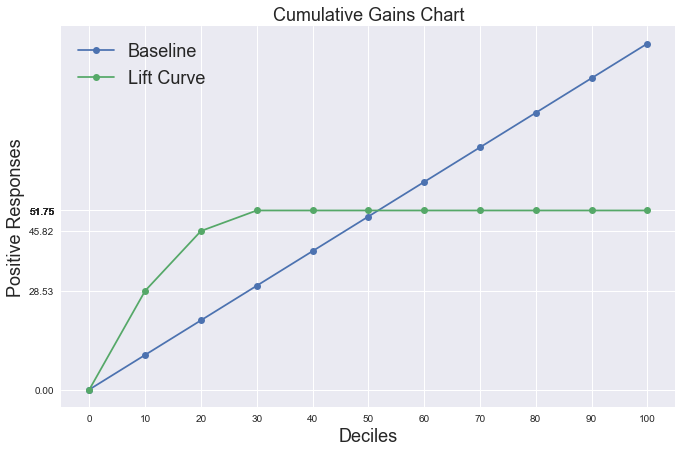

In [184]:
g_l_chart.plot_gain()

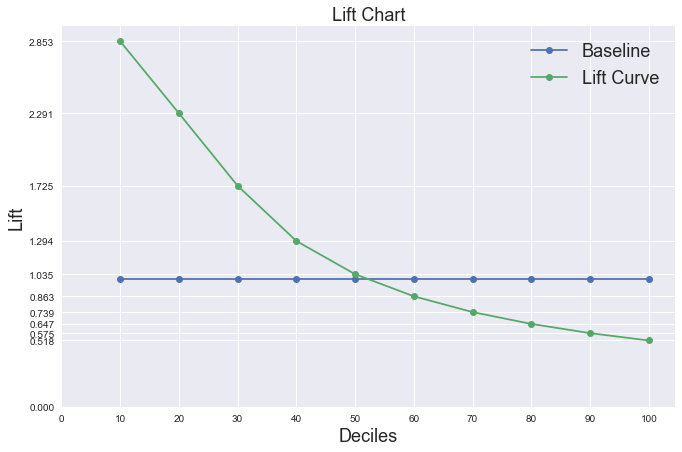

In [185]:
g_l_chart.plot_lift()